In [1]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import pickle

In [2]:
def getDate(filename):
    match_str = re.search(r'\d{4}-\d{2}-\d{2}',filename)
    try:
        return datetime.datetime.strptime(match_str.group(), '%Y-%m-%d').date()
    except ValueError:
        return None

In [3]:
def cleanColumn(name):
    name = name.upper()
    clean_name = re.sub(r'[^a-zA-Z0-9_]', '', name)
    clean_name = clean_name.replace('\n', ' ')
    if clean_name == 'SHELTERNFI':
        clean_name = 'SHELTER'
    if clean_name == 'PROTECTIONCP':
        clean_name = 'PC_CP'
    if clean_name == 'PROTECTIONGBV':
        clean_name = 'PC_GBV'
    if clean_name == 'PROTECTIONMA':
        clean_name = 'PC_MA'
    if clean_name == 'TOTALREACHED':
        clean_name = 'PEOPLEREACHED'
    return clean_name

In [4]:
#using csv and xlsx
csv_dir = 'ukraine_data_excel'


In [5]:
#using xlsx
sheet1_df = []
sheet2_df = []
sheet3_df = []

In [6]:
#using xlsx
for filename in os.listdir(csv_dir):
  if filename.endswith('.xlsx'):
    file_path = os.path.join(csv_dir,filename)
    excel_df = pd.ExcelFile(file_path)
    files_date = getDate(filename)
    for sheet in excel_df.sheet_names:
      df = pd.read_excel(excel_df,sheet_name=sheet)
      df.columns = [cleanColumn(col) for col in df.columns]
      df['DATE'] = files_date
      if sheet == 'Num_of_Orgs_by_Oblast':
        sheet1_df.append(df)
      elif sheet == 'People_Reached_by_Oblast':
        sheet2_df.append(df)
      elif sheet == 'UDE_Inputs':
        sheet3_df.append(df)

In [7]:
combined_sheet1 = pd.concat(sheet1_df, keys=[str(df['DATE'].iloc[0]) for df in sheet1_df])
res_sheet1 = combined_sheet1.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
merged_sheet1 = pd.merge(res_sheet1, combined_sheet1[['ADMIN1_ID', 'DATE', 'OBLAST']], on=['ADMIN1_ID', 'DATE'], how='left')
merged_sheet1.iloc[26]

ADMIN1_ID                                                       UA05
DATE                                                      2022-11-25
OBLAST_x                                                   Vinnytska
CCCM                                                             0.0
CCS                                                              0.0
ETC                                                              0.0
EDUCATION                                                        0.0
FSL                                                              0.0
HEALTH                                                           0.0
LOGISTICS                                                        0.0
MPC                                                              0.0
NUTRITION                                                        0.0
SHELTER                                                          0.0
PROTECTIONTOTAL                                                  0.0
PC_CP                             

In [8]:
combined_sheet2 = pd.concat(sheet2_df, keys=[str(df['DATE'].iloc[0]) for df in sheet2_df])
res_sheet2 = combined_sheet2.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
columns_to_merge = ['ADMIN1_ID', 'DATE'] 
merged_sheet2 = pd.merge(combined_sheet2[combined_sheet2.columns.to_list()], res_sheet2[columns_to_merge] , on=['ADMIN1_ID', 'DATE'], how='right')

In [9]:
merged_sheet2.head()

OBLAST ADMIN1_ID EDUCATION      FSL      CP     GBV  MINEACTION  \
0  Vinnytska      UA05    2800.0   7900.0   100.0   100.0       500.0   
1  Vinnytska      UA05    2800.0  14300.0   100.0  4100.0       500.0   
2  Vinnytska      UA05    4900.0  15500.0   200.0  4100.0       500.0   
3  Vinnytska      UA05    9000.0  17500.0   500.0  6100.0       500.0   
4  Vinnytska      UA05   11500.0  17600.0  4400.0  6200.0       700.0   

   PROTECTIONTOTAL   HEALTH       MPC NUTRITION  SHELTER    WASH  \
0          11900.0   4600.0   91200.0       NaN  15800.0  2300.0   
1          14300.0   4600.0  113000.0       NaN  16200.0  2300.0   
2          16300.0   9900.0  138800.0       NaN  17500.0  3700.0   
3          20300.0  23200.0  140600.0       NaN  17500.0  3700.0   
4          25600.0  23300.0  216600.0       NaN  21700.0  3800.0   

   PEOPLEREACHED        DATE ADM1_ID  GENERALPROTECTION  
0        91200.0  2022-04-28     NaN            11200.0  
1       113000.0  2022-05-06     NaN             9600.0  
2       138800.0  2022-05-12     NaN            11400.0  
3       140600.0  2022-05-19     NaN                NaN  
4       216600.0  2022-05-26     NaN                NaN

In [10]:
merged_sheet2.shape

(675, 17)

In [11]:
merged_sheet2.fillna(0,inplace=True)
merged_sheet2.drop(columns=['ADM1_ID'],inplace=True)

In [12]:
merged_sheet1.isna().any().any()

False

In [13]:
combined_sheet3 = pd.concat(sheet3_df, keys=[str(df['DATE'].iloc[0]) for df in sheet3_df])
res_sheet3 = combined_sheet3.groupby(['ADMIN1_ID', 'DATE']).sum().reset_index()
merged_sheet3 = pd.merge(res_sheet3, combined_sheet3[['ADMIN1_ID', 'DATE', 'OBLAST']], on=['ADMIN1_ID', 'DATE'], how='left')

In [14]:
#Num_of_Orgs_by_Oblast
merged_sheet1.iloc[20:35]

ADMIN1_ID        DATE   OBLAST_x  CCCM  CCS  ETC  EDUCATION   FSL  HEALTH  \
20      UA05  2022-09-22  Vinnytska   2.0  1.0  0.0        4.0  20.0    13.0   
21      UA05  2022-09-29  Vinnytska   3.0  1.0  0.0       10.0  34.0    24.0   
22      UA05  2022-10-06  Vinnytska   0.0  0.0  0.0        0.0   0.0     0.0   
23      UA05  2022-10-13  Vinnytska   3.0  1.0  0.0       11.0  35.0    24.0   
24      UA05  2022-10-27  Vinnytska   3.0  1.0  0.0       13.0  36.0    24.0   
25      UA05  2022-11-10  Vinnytska   0.0  0.0  0.0        0.0   0.0     0.0   
26      UA05  2022-11-25  Vinnytska   0.0  0.0  0.0        0.0   0.0     0.0   
27      UA05  2022-12-08  Vinnytska   3.0  1.0  0.0       13.0  36.0    27.0   
28      UA05  2022-12-22  Vinnytska   2.0  1.0  0.0       13.0  36.0    33.0   
29      UA05  2023-01-05  Vinnytska   3.0  1.0  1.0       17.0  39.0    33.0   
30      UA07  2022-04-28   Volynska   1.0  0.0  0.0        1.0   5.0     6.0   
31      UA07  2022-05-06   Volynska   1.0  0.0  0.0        1.0   6.0     7.0   
32      UA07  2022-05-12   Volynska   1.0  0.0  0.0        1.0   8.0     7.0   
33      UA07  2022-05-19   Volynska   1.0  0.0  0.0        2.0   9.0     8.0   
34      UA07  2022-05-26   Volynska   0.0  0.0  0.0        2.0   9.0     7.0   

    LOGISTICS  ...  SHELTER  PROTECTIONTOTAL  PC_CP  PC_GBV  PC_MA  WASH  \
20        0.0  ...      7.0              0.0    4.0     3.0    3.0   9.0   
21        0.0  ...     23.0              0.0   18.0     7.0    4.0  15.0   
22        0.0  ...      0.0              0.0    0.0     0.0    0.0   0.0   
23        0.0  ...     23.0              0.0   25.0    16.0    5.0  13.0   
24        0.0  ...     23.0              0.0   25.0    10.0    5.0  13.0   
25        0.0  ...      0.0              0.0    0.0     0.0    0.0   0.0   
26        0.0  ...      0.0              0.0    0.0     0.0    0.0   0.0   
27        0.0  ...     24.0              0.0   26.0    11.0    7.0  13.0   
28        0.0  ...     24.0              0.0   29.0    11.0    8.0  13.0   
29        0.0  ...     25.0              0.0   33.0    10.0    8.0  14.0   
30        0.0  ...      4.0             11.0    3.0     3.0    2.0   4.0   
31        0.0  ...      4.0              0.0    4.0     4.0    2.0   4.0   
32        0.0  ...      6.0             15.0    6.0     4.0    2.0   5.0   
33        0.0  ...      6.0             15.0    6.0     4.0    2.0   5.0   
34        0.0  ...      7.0             17.0    7.0     4.0    4.0   5.0   

    TOTAL                                        CLUSTERLIST  PC_PC   OBLAST_y  
20   58.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
21  107.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
22    0.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
23  123.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
24  119.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
25    0.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
26    0.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
27  125.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
28  130.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
29  138.0  Camp Coordination & Camp Management,Coordinati...    0.0  Vinnytska  
30   22.0  Camp Coordination & Camp Management,Education,...    6.0   Volynska  
31   23.0  Camp Coordination & Camp Management,Education,...    6.0   Volynska  
32   29.0  Camp Coordination & Camp Management,Education,...    9.0   Volynska  
33   30.0  Camp Coordination & Camp Management,Education,...    9.0   Volynska  
34   31.0  Education,Food Security and Livelihoods,Health...    7.0   Volynska  

[15 rows x 22 columns]

In [15]:
#People_Reached_by_Oblast
merged_sheet2.iloc[10:25]

OBLAST ADMIN1_ID EDUCATION      FSL        CP      GBV  MINEACTION  \
10  Vinnytska      UA05     16793  39158.0   51426.0   9326.0     99772.0   
11  Vinnytska      UA05     16801  39158.0   51426.0   9326.0    102279.0   
12  Vinnytska      UA05     16812  39158.0   67831.0  21467.0    102669.0   
13  Vinnytska      UA05     16824  39158.0   67831.0  21467.0    102669.0   
14  Vinnytska      UA05     18424  39158.0   67831.0  21467.0    102669.0   
15  Vinnytska      UA05     18439  39158.0   67831.0  21467.0    105178.0   
16  Vinnytska      UA05     18442  39158.0  107050.0  19299.0    105178.0   
17  Vinnytska      UA05     18442  39158.0  107050.0  19299.0    105178.0   
18  Vinnytska      UA05     18505  39158.0  107050.0  19299.0    105178.0   
19  Vinnytska      UA05         0      0.0       0.0      0.0         0.0   
20  Vinnytska      UA05     18519  39158.0  107050.0  19299.0    105178.0   
21  Vinnytska      UA05     18519  39158.0  107050.0  19622.0    105178.0   
22  Vinnytska      UA05         0      0.0       0.0      0.0         0.0   
23  Vinnytska      UA05         0      0.0       0.0      0.0         0.0   
24  Vinnytska      UA05     19499  39158.0  143377.0  20369.0    108493.0   

    PROTECTIONTOTAL    HEALTH       MPC NUTRITION   SHELTER      WASH  \
10         197230.0   38960.0  227756.0         0   65765.0  391243.0   
11         199737.0   38960.0  229081.0         0   74073.0  391243.0   
12         229031.0   38960.0  238079.0         0   84680.0  395394.0   
13         229031.0   43295.0  238270.0         0   84955.0  395394.0   
14         229802.0   43295.0  231601.0         0   85408.0  395394.0   
15         246444.0   88760.0  244098.0         0  103967.0  395394.0   
16         275036.0   88760.0  231215.0         0  105146.0  395394.0   
17         275036.0   88760.0  232815.0         0  105223.0  395394.0   
18         275036.0   88760.0  243513.0         0  107109.0  395394.0   
19              0.0       0.0       0.0         0       0.0       0.0   
20         275036.0   91073.0  243762.0         0  107109.0  395394.0   
21         220783.0   91073.0  246287.0         0  141662.0  395394.0   
22              0.0       0.0       0.0         0       0.0       0.0   
23              0.0       0.0       0.0         0       0.0       0.0   
24         233065.0  112754.0  268036.0         0  155608.0  449220.0   

    PEOPLEREACHED        DATE  GENERALPROTECTION  
10       391243.0  2022-07-28                0.0  
11       391243.0  2022-08-04                0.0  
12       395394.0  2022-08-11                0.0  
13       395394.0  2022-08-18                0.0  
14       395394.0  2022-08-25                0.0  
15       395394.0  2022-09-08                0.0  
16       395394.0  2022-09-15                0.0  
17       395394.0  2022-09-22                0.0  
18       395394.0  2022-09-29                0.0  
19            0.0  2022-10-06                0.0  
20       395394.0  2022-10-13                0.0  
21       395394.0  2022-10-27                0.0  
22            0.0  2022-11-10                0.0  
23            0.0  2022-11-25                0.0  
24       449220.0  2022-12-08                0.0

In [16]:
merged_sheet3.iloc[20:35]

ADMIN1_ID        DATE   OBLAST_x  PEOPLEREACHED  NUMBEROFORGANISATIONS  \
20      UA05  2022-09-22  Vinnytska         395394                     58   
21      UA05  2022-09-29  Vinnytska         395394                    107   
22      UA05  2022-10-06  Vinnytska         449220                    125   
23      UA05  2022-10-13  Vinnytska         395394                    123   
24      UA05  2022-10-27  Vinnytska         395394                    119   
25      UA05  2022-11-10  Vinnytska         449220                    125   
26      UA05  2022-11-25  Vinnytska         449220                    125   
27      UA05  2022-12-08  Vinnytska         449220                    125   
28      UA05  2022-12-22  Vinnytska         449220                    130   
29      UA05  2023-01-05  Vinnytska         449220                    138   
30      UA07  2022-04-28   Volynska          85800                     22   
31      UA07  2022-05-06   Volynska          85800                     23   
32      UA07  2022-05-12   Volynska          85900                     29   
33      UA07  2022-05-19   Volynska          86900                     30   
34      UA07  2022-05-26   Volynska          86900                     31   

                                      CLUSTERSPRESENT   OBLAST_y  
20  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
21  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
22  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
23  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
24  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
25  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
26  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
27  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
28  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
29  Camp Coordination & Camp Management,Coordinati...  Vinnytska  
30  Camp Coordination & Camp Management,Education,...   Volynska  
31  Camp Coordination & Camp Management,Education,...   Volynska  
32  Camp Coordination & Camp Management,Education,...   Volynska  
33  Camp Coordination & Camp Management,Education,...   Volynska  
34  Education,Food Security and Livelihoods,Health...   Volynska

In [17]:
merged_sheet1['OBLAST'].value_counts()

KeyError: 'OBLAST'

In [ ]:
sum(merged_sheet3['PEOPLEREACHED'].value_counts())

750

In [ ]:
merged_sheet1['DATE'].dtype

dtype('O')

In [ ]:
########### mergedsheet 1 prep for interpolation

In [ ]:
# convert date column to string type 
merged_sheet1['DATE'] = merged_sheet1['DATE'].astype(str)
#  the specific date you want to find
specific_date_1006 = '2022-10-06'
specific_date_1125 = '2022-11-25'
specific_date_1110 = '2022-11-10'
# filter the df for rows with the specific date
filtered_values1006 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1006]
filtered_values1110 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1110]
filtered_values1125 = merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1125]

filtered_values1110

ADMIN1_ID        DATE  CCCM  CCS  ETC  EDUCATION  FSL  HEALTH  MPC  \
25       UA05  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
55       UA07  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
85       UA12  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
115      UA14  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
145      UA18  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
175      UA21  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
205      UA23  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
235      UA26  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
265      UA32  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
295      UA35  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
325      UA44  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
355      UA46  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
385      UA48  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
415      UA51  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
445      UA53  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
475      UA56  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
505      UA59  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
535      UA61  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
565      UA63  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
595      UA65  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
625      UA68  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
655      UA71  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
685      UA73  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
715      UA74  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   
745      UA80  2022-11-10   0.0  0.0  0.0        0.0  0.0     0.0  0.0   

     NUTRITION  PROTECTIONTOTAL  PC_CP  PC_GBV  PC_MA  PC_PC  SHELTER  WASH  \
25         0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
55         0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
85         0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
115        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
145        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
175        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
205        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
235        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
265        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
295        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
325        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
355        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
385        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
415        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
445        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
475        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
505        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
535        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
565        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
595        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
625        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
655        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
685        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
715        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   
745        0.0              0.0    0.0     0.0    0.0    0.0      0.0   0.0   

     TOTAL  LOGISTICS   

In [ ]:
# replace zero values in the empty tuple to NAN for future linear interpolation of ORGS
filtered_values1006= filtered_values1006.replace(0,np.nan)
filtered_values1110= filtered_values1110.replace(0,np.nan)
filtered_values1125= filtered_values1125.replace(0,np.nan)

In [ ]:
#overwrite the old values
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1006] = filtered_values1006
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1110] = filtered_values1110
merged_sheet1.loc[merged_sheet1['DATE'] == specific_date_1125] = filtered_values1125

In [ ]:
########### mergedsheet 2 prep for interpolation

In [ ]:
# Convert date column to string type 
merged_sheet2['DATE'] = merged_sheet2['DATE'].astype(str)
# filter the df for rows with the specific date
filtered_values1006_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1006]
filtered_values1110_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1110]
filtered_values1125_m2 = merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1125]
filtered_values1006_m2

OBLAST ADMIN1_ID EDUCATION  FSL  GENERALPROTECTION   CP  GBV  \
19          Vinnytska      UA05         0  0.0                0.0  0.0  0.0   
46           Volynska      UA07         0  0.0                0.0  0.0  0.0   
73    Dnipropetrovska      UA12         0  0.0                0.0  0.0  0.0   
100          Donetska      UA14         0  0.0                0.0  0.0  0.0   
127       Zhytomyrska      UA18         0  0.0                0.0  0.0  0.0   
154       Zakarpatska      UA21         0  0.0                0.0  0.0  0.0   
181         Zaporizka      UA23         0  0.0                0.0  0.0  0.0   
208  Ivano-Frankivska      UA26         0  0.0                0.0  0.0  0.0   
235           Kyivska      UA32         0  0.0                0.0  0.0  0.0   
262     Kirovohradska      UA35         0  0.0                0.0  0.0  0.0   
289          Luhanska      UA44         0  0.0                0.0  0.0  0.0   
316           Lvivska      UA46         0  0.0                0.0  0.0  0.0   
343       Mykolaivska      UA48         0  0.0                0.0  0.0  0.0   
370            Odeska      UA51         0  0.0                0.0  0.0  0.0   
397         Poltavska      UA53         0  0.0                0.0  0.0  0.0   
424         Rivnenska      UA56         0  0.0                0.0  0.0  0.0   
451            Sumska      UA59         0  0.0                0.0  0.0  0.0   
478       Ternopilska      UA61         0  0.0                0.0  0.0  0.0   
505        Kharkivska      UA63         0  0.0                0.0  0.0  0.0   
532        Khersonska      UA65         0  0.0                0.0  0.0  0.0   
559       Khmelnytska      UA68         0  0.0                0.0  0.0  0.0   
586         Cherkaska      UA71         0  0.0                0.0  0.0  0.0   
613      Chernivetska      UA73         0  0.0                0.0  0.0  0.0   
640      Chernihivska      UA74         0  0.0                0.0  0.0  0.0   
667              Kyiv      UA80         0  0.0                0.0  0.0  0.0   

     MINEACTION  PROTECTIONTOTAL  HEALTH  MPC NUTRITION  SHELTER  WASH  \
19          0.0              0.0     0.0  0.0         0      0.0   0.0   
46          0.0              0.0     0.0  0.0         0      0.0   0.0   
73          0.0              0.0     0.0  0.0         0      0.0   0.0   
100         0.0              0.0     0.0  0.0         0      0.0   0.0   
127         0.0              0.0     0.0  0.0         0      0.0   0.0   
154         0.0              0.0     0.0  0.0         0      0.0   0.0   
181         0.0              0.0     0.0  0.0         0      0.0   0.0   
208         0.0              0.0     0.0  0.0         0      0.0   0.0   
235         0.0              0.0     0.0  0.0         0      0.0   0.0   
262         0.0              0.0     0.0  0.0         0      0.0   0.0   
289         0.0              0.0     0.0  0.0         0      0.0   0.0   
316         0.0              0.0     0.0  0.0         0      0.0   0.0   
343         0.0              0.0     0.0  0.0         0      0.0   0.0   
370         0.0              0.0     0.0  0.0         0      0.0   0.0   
397         0.0              0.0     0.0  0.0         0      0.0   0.0   
424         0.0              0.0     0.0  0.0         0      0.0   0.0   
451         0.0              0.0     0.0  0.0         0      0.0   0.0   
478         0.0              0.0     0.0  0.0         0      0.0   0.0   
505         0.0              0.0     0.0  0.0         0      0.0   0.0   
532         0.0              0.0     0.0  0.0         0      0.0   0.0   
559         0.0              0.0     0.0  0.0         0      0.0   0.0   
586         0.0              0.0     0.0  0.0         0      0.0   0.0   
613         0.0              0.0     0.0  0.0         0      0.0   0.0   
640         0.0              0.0     0.0  0.0         0      0.0   0.0   
667         0.0              0.0     0.0  0.0         0      0.0   0.0   

     PEOPLEREACHED        DATE  
19

In [ ]:
# replace zero values in the empty tuple to NAN for future linear interpolation of People
filtered_values1006_m2 = filtered_values1006_m2.replace(0,np.nan)
filtered_values1110_m2 = filtered_values1110_m2.replace(0,np.nan)
filtered_values1125_m2 = filtered_values1125_m2.replace(0,np.nan)

In [ ]:
#overwrite the old values
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1006] = filtered_values1006_m2
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1110] = filtered_values1110_m2
merged_sheet2.loc[merged_sheet2['DATE'] == specific_date_1125] = filtered_values1125_m2

In [ ]:
#check for null values
merged_sheet1.isna().any().any()

True

In [ ]:
# check for null values in specific row
merged_sheet1.iloc[26].isna().any()

True

In [ ]:
#replace dashed in education and nutrition to 0, maybe nan
merged_sheet2 = merged_sheet2.replace('-',0)
e =merged_sheet2[merged_sheet2['EDUCATION']=='-']
n =merged_sheet2[merged_sheet2['NUTRITION']=='-']
e,n

(Empty DataFrame
 Columns: [OBLAST, ADMIN1_ID, EDUCATION, FSL, GENERALPROTECTION, CP, GBV, MINEACTION, PROTECTIONTOTAL, HEALTH, MPC, NUTRITION, SHELTER, WASH, PEOPLEREACHED, DATE]
 Index: [],
 Empty DataFrame
 Columns: [OBLAST, ADMIN1_ID, EDUCATION, FSL, GENERALPROTECTION, CP, GBV, MINEACTION, PROTECTIONTOTAL, HEALTH, MPC, NUTRITION, SHELTER, WASH, PEOPLEREACHED, DATE]
 Index: [])

In [ ]:
#filled null values using linear interpolation
num_of_org_interpolated_df = merged_sheet1.interpolate(method='linear')

In [ ]:
num_of_org_interpolated_df.isna().any().any()

False

In [ ]:
# rounded all int and float dtypes since interpolation caused floats
num_of_org_interpolated_df = num_of_org_interpolated_df.applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

In [ ]:
num_of_org_interpolated_df.loc[num_of_org_interpolated_df['DATE']==specific_date_1110]

In [ ]:
num_of_org_interpolated_df.sort_values(by=['DATE'])

In [ ]:
num_of_org_interpolated_df.describe()

In [ ]:
#filled null values using linear interpolation for merged sheet2
people_reached_interpolated_df = merged_sheet2.interpolate(method='linear')
people_reached_interpolated_df.fillna(method='ffill',inplace=True)

In [ ]:
#check for null
people_reached_interpolated_df.isna().any().any()

False

In [ ]:
# rounded all int and float dtypes since interpolation caused floats
people_reached_interpolated_df = people_reached_interpolated_df.applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

In [ ]:
people_reached_interpolated_df.loc[people_reached_interpolated_df['DATE']==specific_date_1125]

In [ ]:
#NUM OF ORGS
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Oblast column
encoded_oblast = label_encoder.fit_transform(num_of_org_interpolated_df['OBLAST'])
#create copy
num_of_org_df_encoded = num_of_org_interpolated_df.copy()
#Add column and assign values
num_of_org_df_encoded['OBLAST_ENCODED'] = encoded_oblast

In [ ]:
#NUM OF ORGS
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Date column
encoded_oblast = label_encoder.fit_transform(num_of_org_df_encoded['DATE'])
#create copy
num_of_org_df_encode = num_of_org_df_encoded.copy()
#Add column and assign values
num_of_org_df_encode['DATE_ENCODED'] = encoded_oblast

In [ ]:
#PEOPLE REACHED
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Oblast column
encoded_oblast = label_encoder.fit_transform(people_reached_interpolated_df['OBLAST'])
#create copy
people_reached_df_encoded = people_reached_interpolated_df.copy()
#Add column and assign values
people_reached_df_encoded['OBLAST_ENCODED'] = encoded_oblast

NameError: name 'LabelEncoder' is not defined

In [ ]:
#PEOPLE REACHED
# create label encoder instance
label_encoder = LabelEncoder()
#fit label encoder to transform Date column
encoded_oblast = label_encoder.fit_transform(people_reached_df_encoded['DATE'])
#create copy
people_reached_df_encode = people_reached_df_encoded.copy()
#Add column and assign values
people_reached_df_encode['DATE_ENCODED'] = encoded_oblast

NameError: name 'df_encoded' is not defined

In [ ]:
#changing the name of the df
people_reached = people_reached_df_encode
num_of_org = num_of_org_df_encode

In [ ]:
people_reached.sort_values(by=['DATE'])

In [ ]:
people_reached['OBLAST'].unique()

In [ ]:
# Creating lists based on geographical location
western_region = ['Vinnytska', 'Volynska', 'Zakarpatska', 'Ivano-Frankivska', 'Lvivska', 'Ternopilska']
northern_region = ['Zhytomyrska', 'Rivnenska', 'Chernihivska', 'Kyiv']
central_region = ['Dnipropetrovska', 'Kyivska', 'Kirovohradska', 'Poltavska', 'Khmelnytska', 'Cherkaska']
eastern_region = ['Donetska', 'Luhanska', 'Kharkivska', 'Sumska']
southern_region = ['Zaporizka', 'Mykolaivska', 'Odeska', 'Khersonska', 'Chernivetska']
dfw = people_reached[people_reached['OBLAST'].isin(western_region)]
dfn = people_reached[people_reached['OBLAST'].isin(northern_region)]
dfc = people_reached[people_reached['OBLAST'].isin(central_region)]
dfe = people_reached[people_reached['OBLAST'].isin(eastern_region)]
dfs = people_reached[people_reached['OBLAST'].isin(southern_region)]


In [ ]:
top5_oblast_people_reached = ['Lvivska','Kyiv','Dnipropetrovska','Kharkivska','Zaporizka']
temp = num_of_org[num_of_org['OBLAST'].isin(top5_oblast_people_reached)]
temp

ADMIN1_ID        DATE  CCCM  CCS  ETC  EDUCATION   FSL  HEALTH   MPC  \
60       UA12  2022-04-28   1.0  1.0  1.0        3.0  31.0    19.0  12.0   
61       UA12  2022-05-06   1.0  1.0  1.0        3.0  35.0    22.0  11.0   
62       UA12  2022-05-12   1.0  1.0  1.0        3.0  47.0    24.0  10.0   
63       UA12  2022-05-19   1.0  1.0  1.0        4.0  42.0    25.0  10.0   
64       UA12  2022-05-26   0.0  1.0  1.0        5.0  42.0    28.0   9.0   
..        ...         ...   ...  ...  ...        ...   ...     ...   ...   
745      UA80  2022-11-10   0.3  1.0  1.0       12.7  42.7    51.3  18.3   
746      UA80  2022-11-25   0.7  1.0  1.0       13.3  43.3    51.7  20.7   
747      UA80  2022-12-08   1.0  1.0  1.0       14.0  44.0    52.0  23.0   
748      UA80  2022-12-22   1.0  1.0  1.0       14.0  44.0    63.0  23.0   
749      UA80  2023-01-05   0.0  1.0  1.0       18.0  45.0    63.0  26.0   

     NUTRITION  ...  PC_GBV  PC_MA  PC_PC  SHELTER  WASH  TOTAL  LOGISTICS  \
60         2.0  ...     4.0    2.0   14.0     10.0  15.0   58.0        0.0   
61         2.0  ...     5.0    2.0   15.0     12.0  15.0   64.0        0.0   
62         2.0  ...     6.0    2.0   19.0     12.0  17.0   75.0        0.0   
63         2.0  ...     6.0    2.0   19.0     12.0  17.0   73.0        0.0   
64         2.0  ...     6.0    4.0   18.0     13.0  18.0   74.0        0.0   
..         ...  ...     ...    ...    ...      ...   ...    ...        ...   
745        3.0  ...    16.3    8.7    0.0     11.0  13.3  139.0        1.0   
746        3.0  ...    16.7    8.3    0.0     12.0  13.7  143.0        1.0   
747        3.0  ...    17.0    8.0    0.0     13.0  14.0  147.0        1.0   
748        3.0  ...    17.0    8.0    0.0     13.0  14.0  159.0        1.0   
749        3.0  ...    16.0   10.0    0.0     13.0  15.0  167.0        1.0   

              OBLAST  OBLAST_ENCODED DATE_ENCODED  
60   Dnipropetrovska               3            0  
61   Dnipropetrovska               3            1  
62   Dnipropetrovska               3            2  
63   Dnipropetrovska               3            3  
64   Dnipropetrovska               3            4  
..               ...             ...          ...  
745             Kyiv              10           25  
746             Kyiv              10           26  
747             Kyiv              10           27  
748             Kyiv              10           28  
749             Kyiv              10           29  

[150 rows x 22 columns]

C:\Users\rober\AppData\Local\Temp\ipykernel_20000\650877304.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = temp.groupby(['OBLAST']).sum()


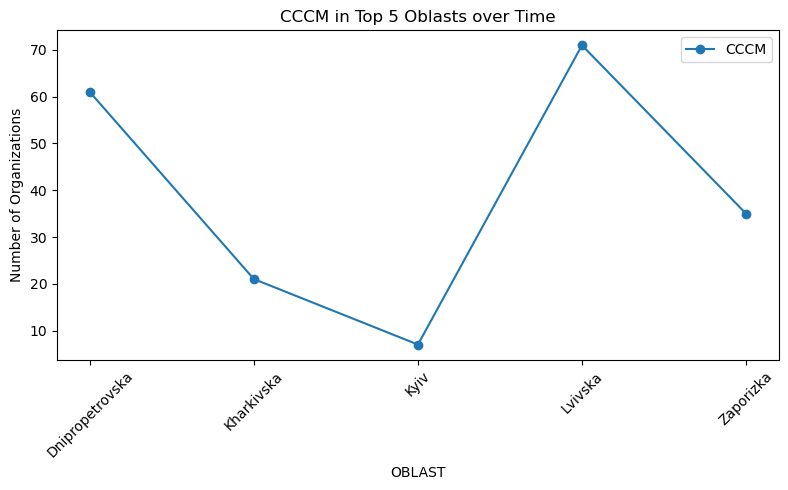

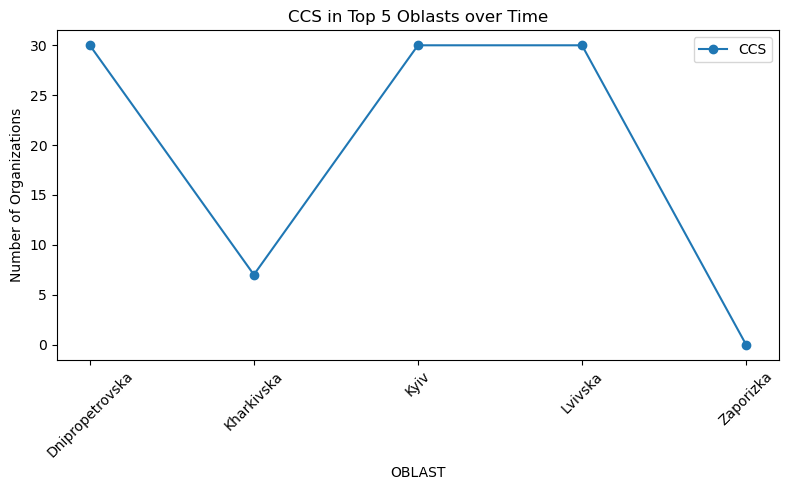

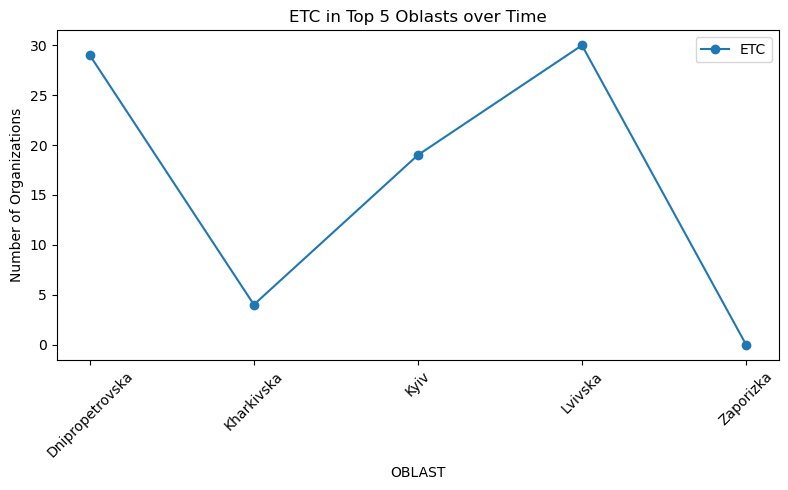

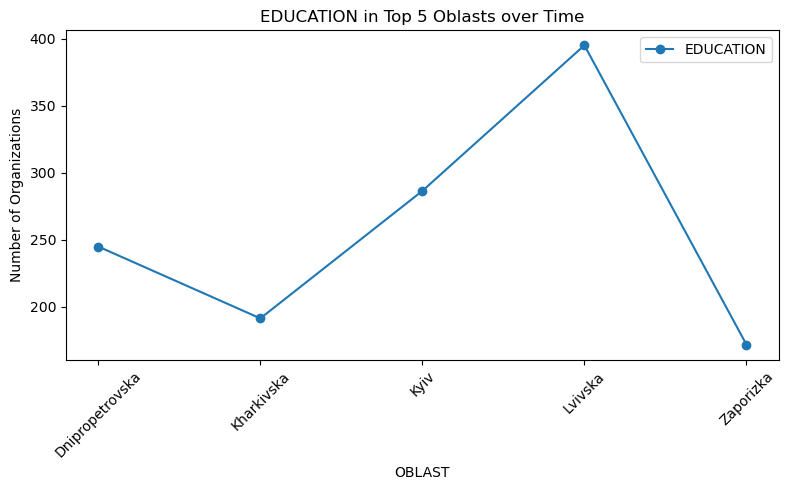

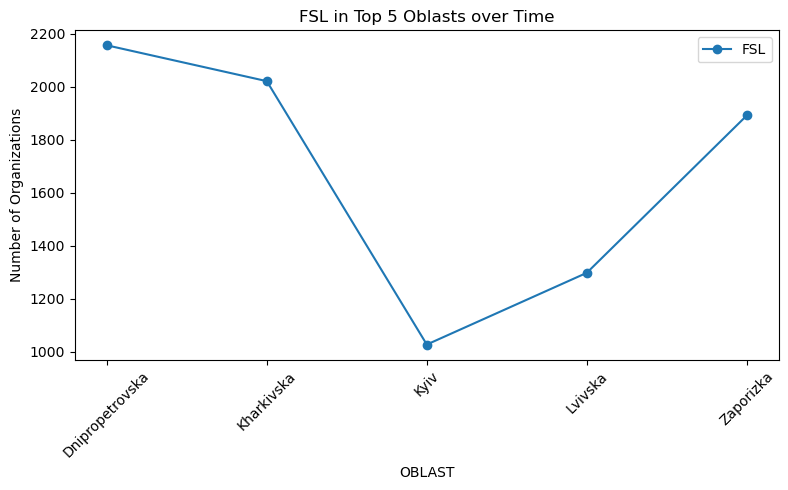

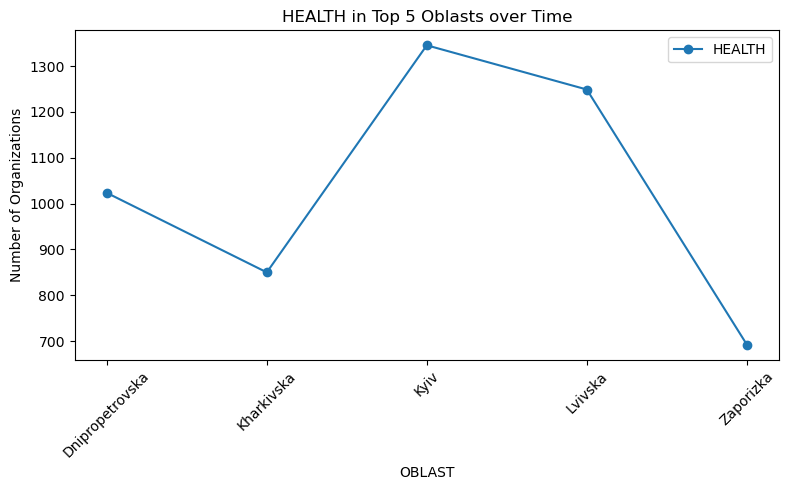

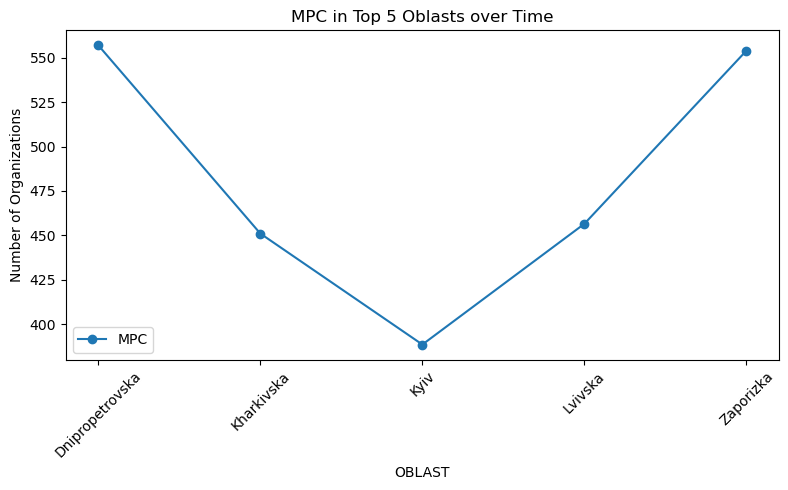

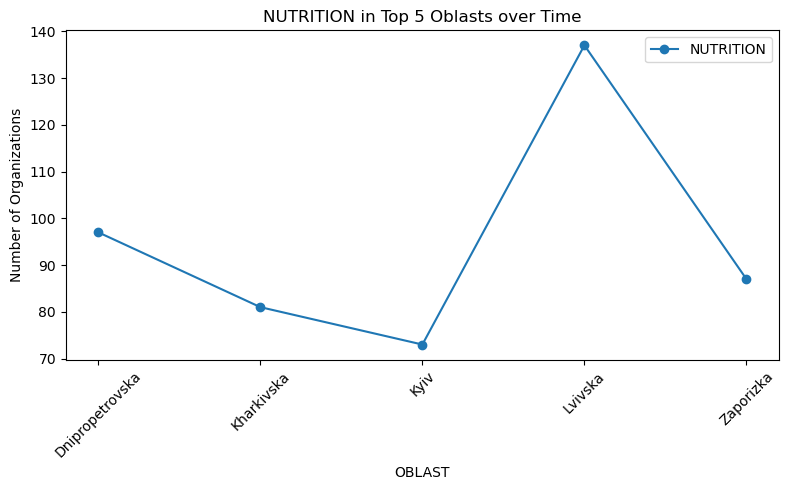

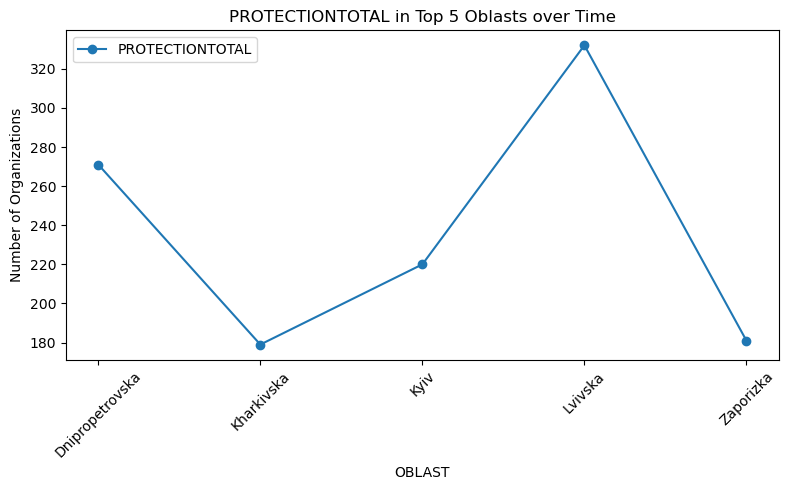

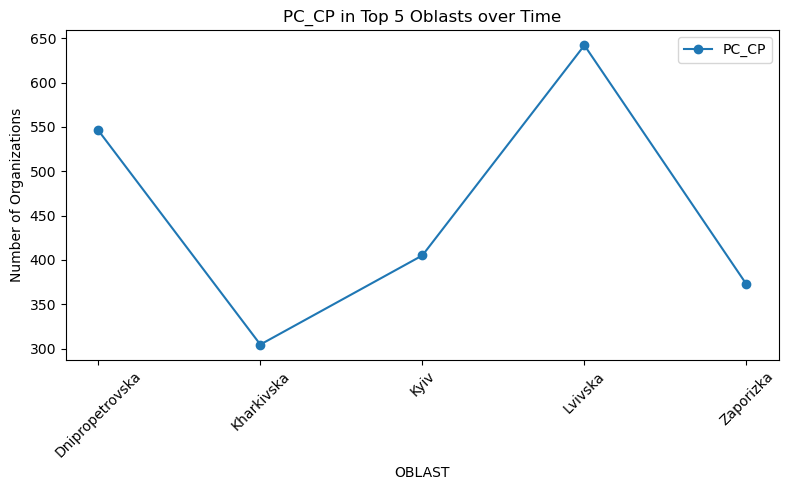

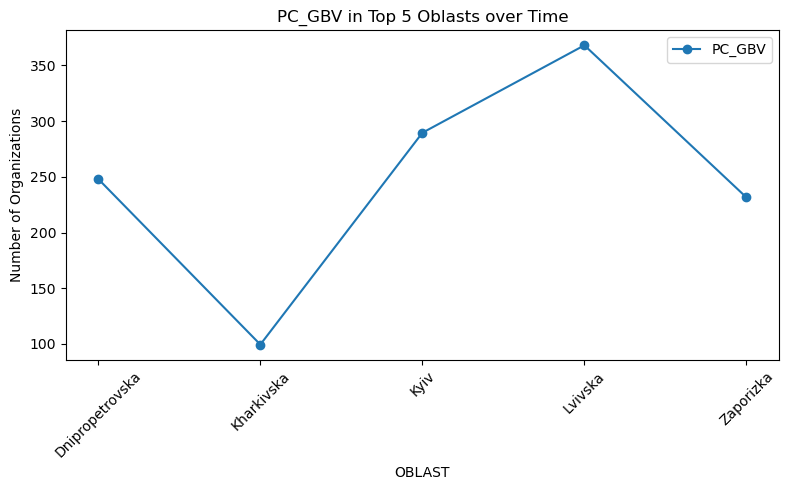

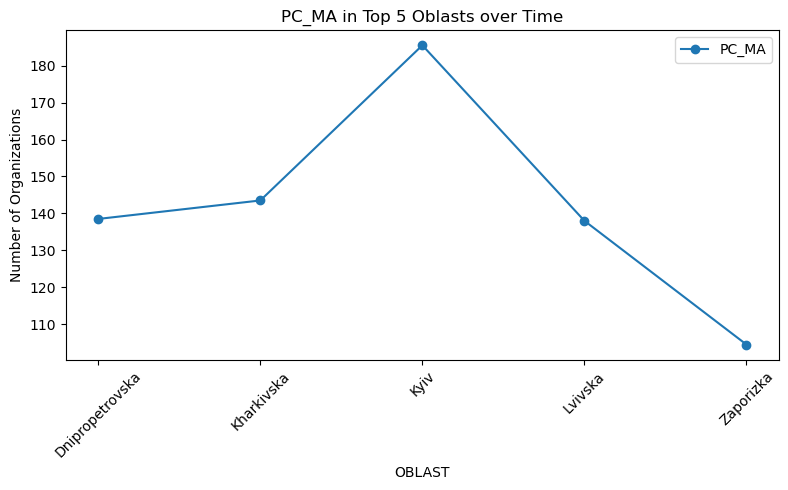

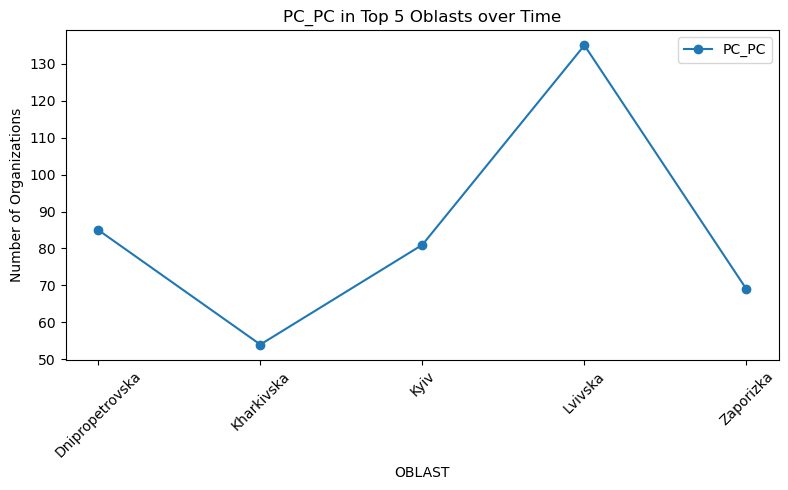

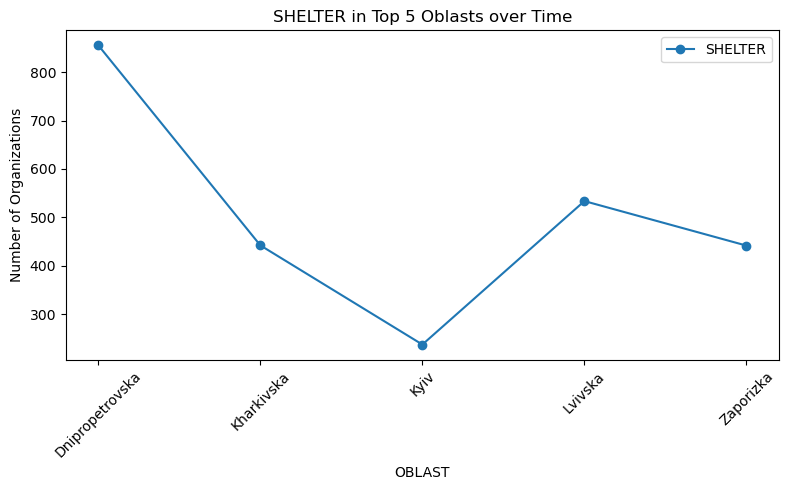

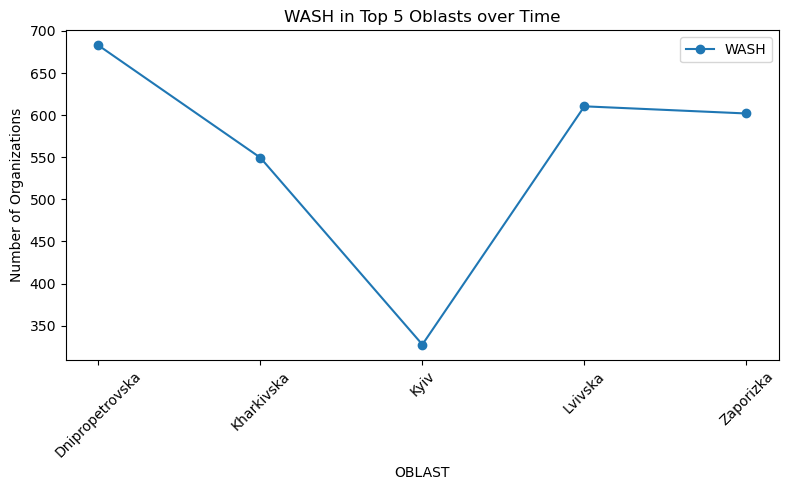

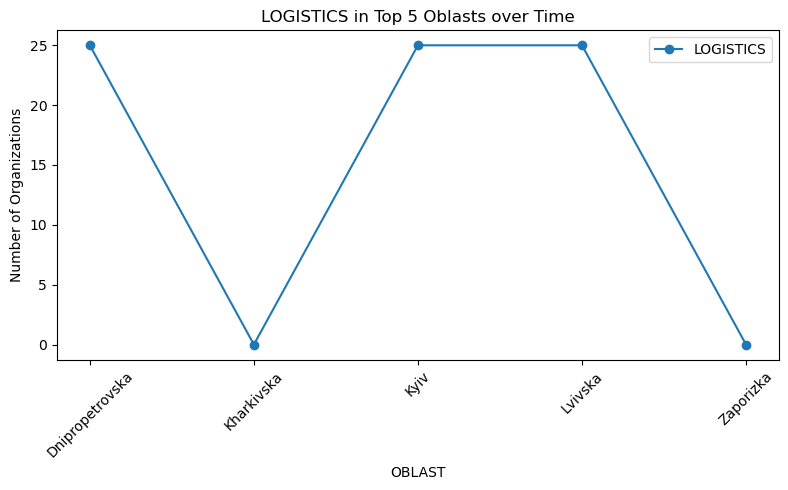

In [ ]:

# Group the filtered data by 'DATE' and calculate the sum of each need for the top 5 oblasts
grouped_data = temp.groupby(['OBLAST']).sum()
grouped_data.drop(columns=['OBLAST_ENCODED', 'DATE_ENCODED','TOTAL'], inplace=True)
# Plot each need over time for the top 5 oblasts
for column in grouped_data.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(grouped_data.index, grouped_data[column], marker='o', linestyle='-', label=column)
    plt.title(f'{column} in Top 5 Oblasts over Time')
    plt.xlabel('OBLAST')
    plt.ylabel('Number of Organizations')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
grouped_data

CCCM   CCS   ETC  EDUCATION     FSL  HEALTH    MPC  \
OBLAST                                                                
Dnipropetrovska  61.0  30.0  29.0      245.0  2157.0  1023.5  557.0   
Kharkivska       21.0   7.0   4.0      191.5  2021.5   850.0  451.0   
Kyiv              7.0  30.0  19.0      286.5  1026.5  1345.5  388.5   
Lvivska          71.0  30.0  30.0      395.0  1297.5  1249.0  456.5   
Zaporizka        35.0   0.0   0.0      172.0  1892.0   692.5  554.0   

                 NUTRITION  PROTECTIONTOTAL  PC_CP  PC_GBV  PC_MA  PC_PC  \
OBLAST                                                                     
Dnipropetrovska       97.0            271.0  546.0   248.0  138.5   85.0   
Kharkivska            81.0            179.0  304.5    99.5  143.5   54.0   
Kyiv                  73.0            220.0  405.0   289.5  185.5   81.0   
Lvivska              137.0            332.0  642.0   368.0  138.0  135.0   
Zaporizka             87.0            181.0  372.5   231.5  104.5   69.0   

                 SHELTER   WASH   TOTAL  LOGISTICS  OBLAST_ENCODED  \
OBLAST                                                               
Dnipropetrovska    855.5  683.0  4129.0       25.0              90   
Kharkivska         442.0  549.5  3042.0        0.0             180   
Kyiv               237.0  327.5  2862.0       25.0             300   
Lvivska            533.5  610.5  3602.0       25.0             390   
Zaporizka          441.5  602.0  2876.0        0.0             690   

                 DATE_ENCODED  
OBLAST                         
Dnipropetrovska           435  
Kharkivska                435  
Kyiv                      435  
Lvivska                   435  
Zaporizka                 435

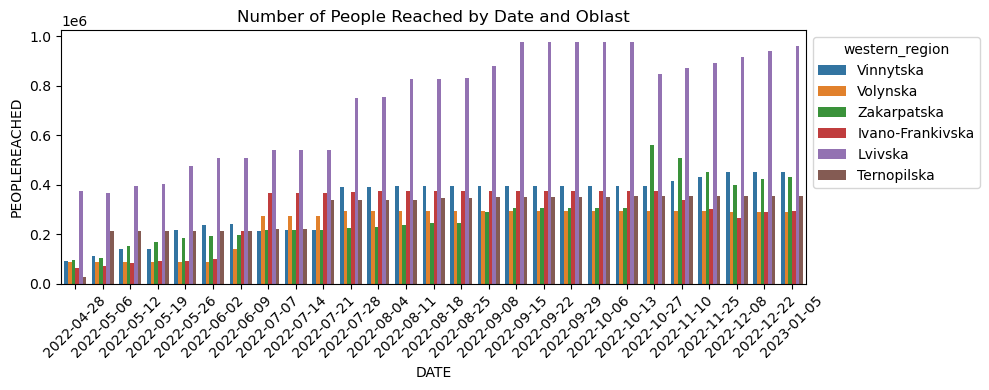

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfw, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='western_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

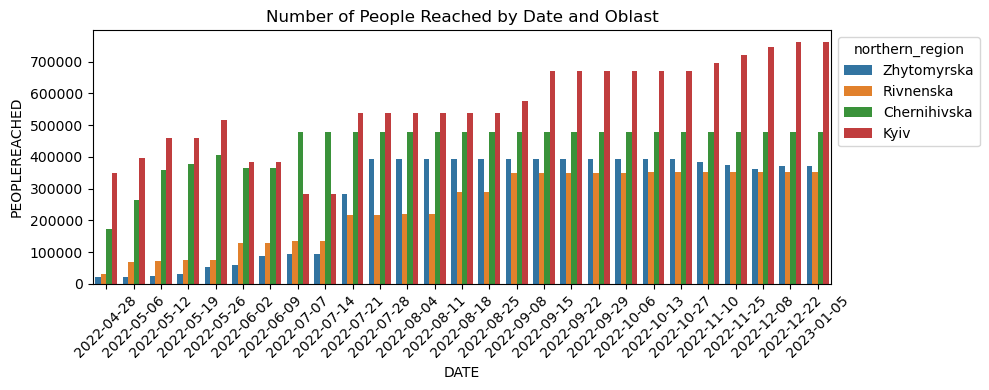

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfn, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='northern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

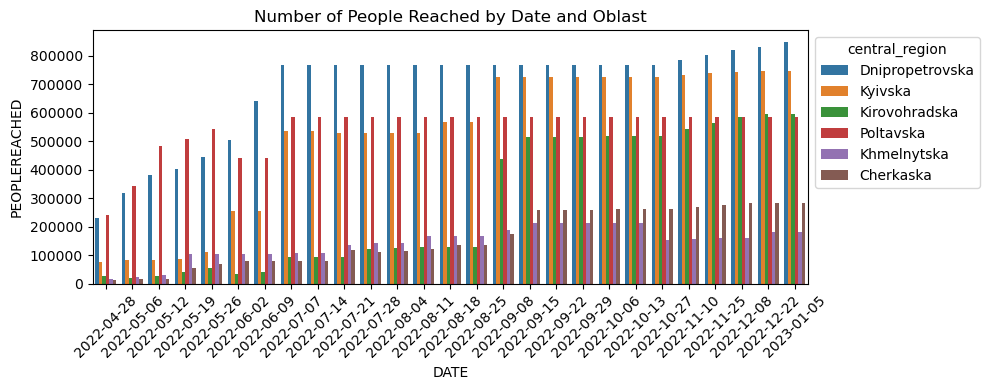

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfc, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='central_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

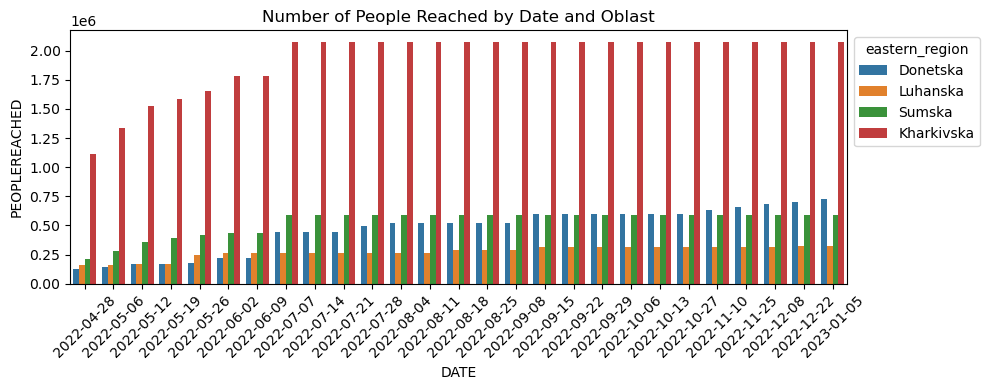

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfe, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='eastern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

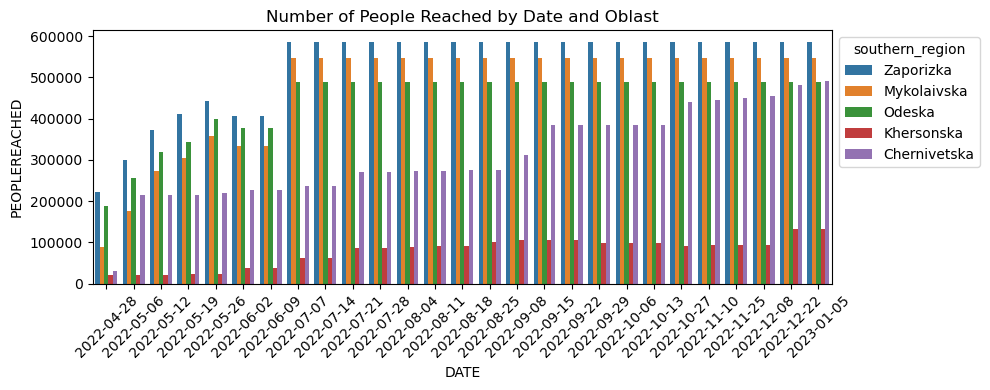

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=dfs, x='DATE', y='PEOPLEREACHED', hue='OBLAST')
plt.title('Number of People Reached by Date and Oblast')
plt.xticks(rotation=45)
plt.legend(title='southern_region', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
num_of_org.iloc[2:5]

ADMIN1_ID        DATE  CCCM  CCS  ETC  EDUCATION   FSL  HEALTH   MPC  \
2      UA05  2022-05-12   2.0  1.0  1.0        6.0  20.0    18.0  10.0   
3      UA05  2022-05-19   2.0  1.0  1.0        6.0  20.0    20.0  10.0   
4      UA05  2022-05-26   0.0  1.0  1.0        6.0  20.0    20.0   9.0   

   NUTRITION  ...  PC_GBV  PC_MA  PC_PC  SHELTER  WASH  TOTAL  LOGISTICS  \
2        0.0  ...     4.0    2.0   14.0      6.0   9.0   49.0        0.0   
3        0.0  ...     4.0    2.0   14.0      6.0   9.0   50.0        0.0   
4        0.0  ...     4.0    4.0   12.0      7.0   9.0   48.0        0.0   

      OBLAST  OBLAST_ENCODED DATE_ENCODED  
2  Vinnytska              20            2  
3  Vinnytska              20            3  
4  Vinnytska              20            4  

[3 rows x 22 columns]

In [ ]:
people_reached.describe()

EDUCATION           FSL  GENERALPROTECTION            CP  \
count    675.000000  6.750000e+02         675.000000     675.00000   
mean   13144.528889  3.223601e+05        1079.851852   48951.50963   
std    15882.226539  4.020878e+05        4596.280587   64356.53692   
min        0.000000  7.900000e+03           0.000000       0.00000   
25%     1100.000000  6.280800e+04           0.000000    3300.00000   
50%     6482.000000  1.294000e+05           0.000000   22900.00000   
75%    20400.000000  5.119000e+05           0.000000   73111.50000   
max    64643.000000  2.070200e+06       37900.000000  372667.00000   

                GBV     MINEACTION  PROTECTIONTOTAL         HEALTH  \
count    675.000000     675.000000       675.000000     675.000000   
mean   10075.069630   87349.311111    169513.685926  229081.474815   
std     9379.233431   81629.120822    172213.859271  180738.593741   
min        0.000000       0.000000       800.000000     700.000000   
25%     2150.000000    1550.000000     35550.000000   85750.000000   
50%     7600.000000   85592.000000    133087.000000  211600.000000   
75%    15446.350000  117536.000000    235802.500000  345422.500000   
max    54959.000000  352145.000000    974403.000000  761036.000000   

                 MPC     NUTRITION        SHELTER          WASH  \
count     675.000000    675.000000     675.000000  6.750000e+02   
mean   113779.737037   4289.413333   51623.983704  1.793157e+05   
std     91701.233400   5480.722386   62037.192128  2.127466e+05   
min         0.000000      0.000000     200.000000  0.000000e+00   
25%     41983.500000      0.000000   12873.500000  2.500000e+04   
50%    101214.000000   2000.000000   31700.000000  1.026610e+05   
75%    159354.500000   7700.000000   69420.000000  2.943350e+05   
max    523050.000000  22800.000000  505784.000000  1.595189e+06   

       PEOPLEREACHED  OBLAST_ENCODED  DATE_ENCODED  
count   6.750000e+02       675.00000    675.000000  
mean    4.422679e+05        12.00000     13.000000  
std     3.730008e+05         7.21645      7.794657  
min     1.380000e+04         0.00000      0.000000  
25%     2.192840e+05         6.00000      6.000000  
50%     3.772000e+05        12.00000     13.000000  
75%     5.458000e+05        18.00000     20.000000  
max     2.070200e+06        24.00000     26.000000

In [ ]:
people_reached.columns

Index(['OBLAST', 'ADMIN1_ID', 'EDUCATION', 'FSL', 'GENERALPROTECTION', 'CP',
       'GBV', 'MINEACTION', 'PROTECTIONTOTAL', 'HEALTH', 'MPC', 'NUTRITION',
       'SHELTER', 'WASH', 'PEOPLEREACHED', 'DATE', 'OBLAST_ENCODED',
       'DATE_ENCODED'],
      dtype='object')

In [ ]:
search_result = people_reached[people_reached['EDUCATION'] == '-']
search_result

Empty DataFrame
Columns: [OBLAST, ADMIN1_ID, EDUCATION, FSL, GENERALPROTECTION, CP, GBV, MINEACTION, PROTECTIONTOTAL, HEALTH, MPC, NUTRITION, SHELTER, WASH, PEOPLEREACHED, DATE, OBLAST_ENCODED, DATE_ENCODED]
Index: []

In [ ]:
search_result = people_reached[people_reached['NUTRITION'] == '-']
search_result.shape

(0, 18)

In [ ]:
num_of_org.columns

Index(['ADMIN1_ID', 'DATE', 'CCCM', 'CCS', 'ETC', 'EDUCATION', 'FSL', 'HEALTH',
       'MPC', 'NUTRITION', 'PROTECTIONTOTAL', 'PC_CP', 'PC_GBV', 'PC_MA',
       'PC_PC', 'SHELTER', 'WASH', 'TOTAL', 'LOGISTICS', 'OBLAST',
       'OBLAST_ENCODED', 'DATE_ENCODED'],
      dtype='object')

In [ ]:
def grid_search(X_train, X_test, y_train, y_test):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50,100, 200, 300],
        'learning_rate': [0.1, 0.05,0.25, 0.01],
        'max_depth': [3, 4, 5,6],
        'min_samples_leaf': [1, 2, 3, 4],
        'min_samples_split': [2, 3, 4, 5],
        'subsample': [0.6,0.8, 0.9, 1.0],
    }

    # Initialize the model
    gbdt_model = GradientBoostingRegressor()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(gbdt_model, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(X_train, y_train)

   
    best_params = grid_search.best_params_
    print('Best parameters: {0}'.format(best_params))
    best_model = grid_search.best_estimator_
    print('Best model: {0}'.format(best_model))
  
    best_model.fit(X_train, y_train)
    y_gbdt_best_pred = best_model.predict(X_test)
    gbdt_rmse = mean_squared_error(y_test, y_gbdt_best_pred, squared=False)
    gbdt_r2 = r2_score(y_test, y_gbdt_best_pred)

    print('[GBDT] Root Mean Squared Error: {0}'.format(gbdt_rmse))
    print('[GBDT] R2: {0}'.format(gbdt_r2))


In [ ]:
#PEOPLE REACHED MODEL 
y_pr = people_reached['PEOPLEREACHED']
X_pr = people_reached.drop(columns=['PEOPLEREACHED','GENERALPROTECTION','OBLAST','DATE','ADMIN1_ID'],axis=1)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, test_size=0.2, random_state=42)

In [ ]:
peopleReached = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=6, min_samples_split=8, n_estimators=300, subsample=0.8)
peopleReached.fit(X_train_pr,y_train_pr)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=8,
                          n_estimators=300, subsample=0.8)

In [ ]:
pr_rmse = mean_squared_error(y_test_pr, peopleReached.predict(X_test_pr), squared=False)
pr_r2 = r2_score(y_test_pr, peopleReached.predict(X_test_pr))
print('[GBDT] Root Mean Squared Error: {0}'.format(pr_rmse))
print('[GBDT] R2: {0}'.format(pr_r2))

[GBDT] Root Mean Squared Error: 20714.240837895948
[GBDT] R2: 0.9944075695357416


In [ ]:
#CCCM
y_cccm = num_of_org['CCCM']
X_cccm = num_of_org.drop(columns=['CCCM','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_cccm, X_test_cccm, y_train_cccm, y_test_cccm = train_test_split(X_cccm, y_cccm, test_size=0.2, random_state=42)

In [ ]:
Cccm = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6)
Cccm.fit(X_train_cccm,y_train_cccm)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, subsample=0.6)

In [ ]:
cccm_rmse = mean_squared_error(y_test_cccm, Cccm.predict(X_test_cccm), squared=False)
cccm_r2 = r2_score(y_test_cccm, Cccm.predict(X_test_cccm))
print('[GBDT] Root Mean Squared Error: {0}'.format(cccm_rmse))
print('[GBDT] R2: {0}'.format(cccm_r2))

[GBDT] Root Mean Squared Error: 0.42562595397734493
[GBDT] R2: 0.8748396304144401


In [ ]:
#EDUCATION
y_etc = num_of_org['ETC']
X_etc = num_of_org.drop(columns=['ETC','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_etc , X_test_etc, y_train_etc, y_test_etc = train_test_split(X_etc, y_etc, test_size=0.2, random_state=42)

In [ ]:
etc = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6)
etc.fit(X_train_etc,y_train_etc)

GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=300,
                          subsample=0.6)

In [ ]:
etc_rmse = mean_squared_error(y_test_etc, etc.predict(X_test_etc), squared=False)
etc_r2 = r2_score(y_test_etc, etc.predict(X_test_etc))  
print('[GBDT] Root Mean Squared Error: {0}'.format(etc_rmse))
print('[GBDT] R2: {0}'.format(etc_r2))

[GBDT] Root Mean Squared Error: 0.1447550959383035
[GBDT] R2: 0.881225207146045


In [ ]:
#CCS
y_ccs = num_of_org['CCS']
X_ccs = num_of_org.drop(columns=['CCS','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_ccs , X_test_ccs, y_train_ccs, y_test_ccs = train_test_split(X_ccs, y_ccs, test_size=0.2, random_state=42)

In [ ]:
ccs = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0)
ccs.fit(X_train_ccs,y_train_ccs)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=2, n_estimators=300)

In [ ]:
ccs_rmse = mean_squared_error(y_test_ccs, ccs.predict(X_test_ccs), squared=False)
ccs_r2 = r2_score(y_test_ccs, ccs.predict(X_test_ccs))
print('[GBDT] Root Mean Squared Error: {0}'.format(ccs_rmse))
print('[GBDT] R2: {0}'.format(ccs_r2))

[GBDT] Root Mean Squared Error: 0.06860384116985115
[GBDT] R2: 0.9802764093828816


In [ ]:
#Total
y_total = num_of_org['TOTAL']
X_total = num_of_org.drop(columns=['TOTAL','OBLAST','DATE','ADMIN1_ID','PROTECTIONTOTAL'],axis=1)
X_train_total , X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [ ]:
total = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.6)
total.fit(X_train_total,y_train_total)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=5,
                          n_estimators=300, subsample=0.6)

In [ ]:
total_rmse = mean_squared_error(y_test_total, total.predict(X_test_total), squared=False)
total_r2 = r2_score(y_test_total, total.predict(X_test_total))
print('[GBDT] Root Mean Squared Error: {0}'.format(total_rmse))
print('[GBDT] R2: {0}'.format(total_r2))

[GBDT] Root Mean Squared Error: 3.2359692976669936
[GBDT] R2: 0.9940232452435666


In [ ]:
y_pccp = num_of_org_df_encode['PC_CP']
X_pccp = num_of_org_df_encode.drop(columns = ['PC_CP', 'ADMIN1_ID','DATE','OBLAST'])


X_train_pccp, X_test_pccp, y_train_pccp, y_test_pccp = train_test_split(X_pccp, y_pccp, test_size=0.10, random_state=1234)


In [ ]:
pccp = GradientBoostingRegressor(n_estimators=64, max_depth=4)
pccp.fit(X_train_pccp, y_train_pccp)

In [ ]:
pccp_rmse = mean_squared_error(y_test_pccp, pccp.predict(X_test_pccp), squared=False)
pccp_r2 = r2_score(y_test_pccp, pccp.predict(X_test_pccp))
print('[GBDT] Root Mean Squared Error: {0}'.format(pccp_rmse))
print('[GBDT] R2: {0}'.format(pccp_r2))

In [ ]:
y_pcgbv = num_of_org_df_encode['PC_GBV']
X_pcgbv = num_of_org_df_encode.drop(columns = ['PC_GBV', 'ADMIN1_ID','DATE','OBLAST'])

X_train_pcgbv, X_test_pcgbv, y_train_pcgbv, y_test_pcgbv = train_test_split(X_pcgbv, y_pcgbv, test_size=0.10, random_state=1234)

In [ ]:
pcgbv = GradientBoostingRegressor(n_estimators=64, max_depth=4)
pcgbv.fit(X_train_pcgbv, y_train_pcgbv)

In [ ]:
pcgbv_rmse = mean_squared_error(y_test_pcgbv, pcgbv.predict(X_test_pcgbv), squared=False)
pcgbv_r2 = r2_score(y_test_pcgbv, pcgbv.predict(X_test_pcgbv))
print('[GBDT] Root Mean Squared Error: {0}'.format(pcgbv_rmse))
print('[GBDT] R2: {0}'.format(pcgbv_r2))

In [ ]:
y_pcma = num_of_org_df_encode['PC_MA']
X_pcma = num_of_org_df_encode.drop(columns = ['PC_MA', 'ADMIN1_ID','DATE','OBLAST'])

X_train_pcma, X_test_pcma, y_train_pcma, y_test_pcma = train_test_split(X_pcma, y_pcma, test_size=0.10, random_state=1234)


In [ ]:
pcma = GradientBoostingRegressor(n_estimators=64, max_depth=4)
pcma.fit(X_train_pcma, y_train_pcma)

In [ ]:
pcma_rmse = mean_squared_error(y_test_pcma, pcma.predict(X_test_pcma), squared=False)
pcma_r2 = r2_score(y_test_pcma, pcma.predict(X_test_pcma))
print('[GBDT] Root Mean Squared Error: {0}'.format(pcma_rmse))
print('[GBDT] R2: {0}'.format(pcma_r2))